Predict image labels using an Estimator.

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.optimizers import RMSprop
from camvid_dataset import dataset, load_camvid_tfrecords
from keras_fc_densenet import build_FC_DenseNet56, build_FC_DenseNet67, build_FC_DenseNet103
from camvid_utils import load_label_colors, color_label, show_image_row, unnormalize_image

In [3]:
label_colors_path = './camvid/label_colors.txt'
label_colors, _, _ = load_label_colors(label_colors_path)

In [4]:
camvid_path = './camvid-preprocessed/camvid-384x480-test.tfrecords'
with tf.Session() as sess:
    images, labels = load_camvid_tfrecords(sess, camvid_path, 20)

In [8]:
tf.reset_default_graph()

model_dir = '/tmp/retrained_model'

def train_input_fn():
    ds = dataset(camvid_path)
    ds = ds.take(10)
    ds = ds.batch(1)
    return ds

fc_dn_model = build_FC_DenseNet103(nb_classes=32, final_softmax=True, dropout_rate=0.0, input_shape=(384, 480, 3))
fc_dn_model.compile(optimizer=RMSprop(lr=1e-4), 
                    loss='sparse_categorical_crossentropy')

estimator = tf.keras.estimator.model_to_estimator(keras_model=fc_dn_model, 
                                                      model_dir=model_dir)


INFO:tensorflow:Layers in each dense block: [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
INFO:tensorflow:Number of skip connections: 5
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/retrained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x182b0aa898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
predictions = estimator.predict(input_fn=train_input_fn)
predicted_labels = [np.argmax(pred['softmax'], axis=-1) for pred in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/retrained_model/model.ckpt-37120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Original image / true labels / predicted labels


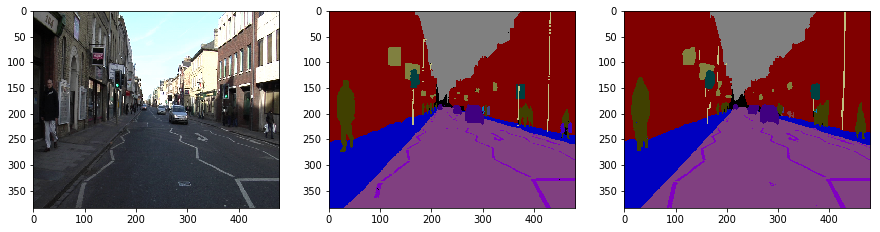

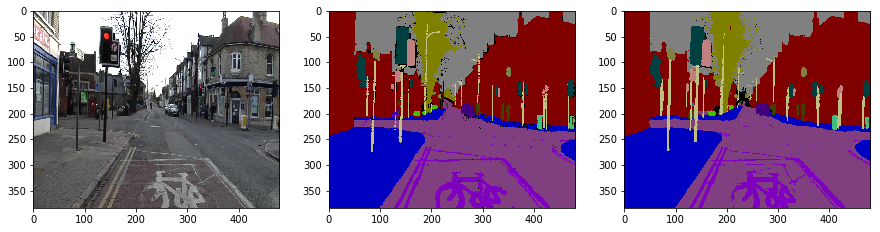

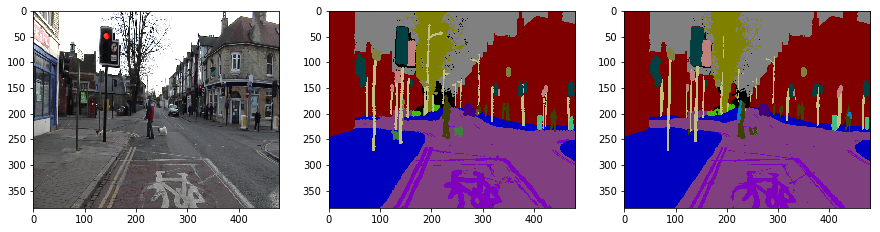

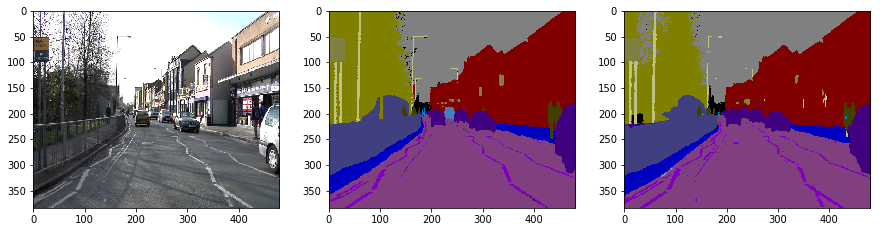

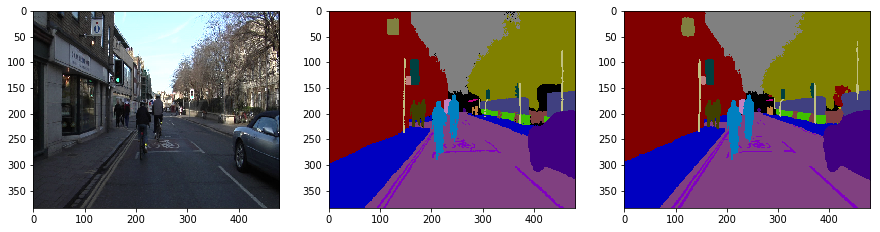

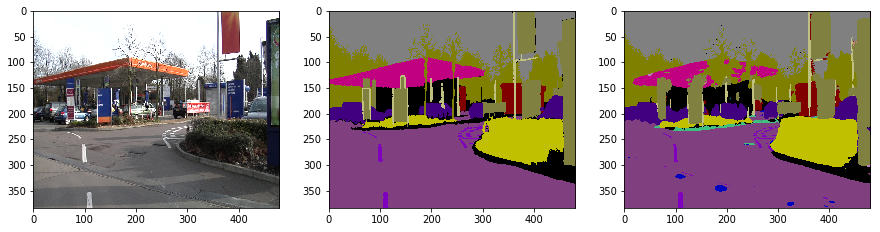

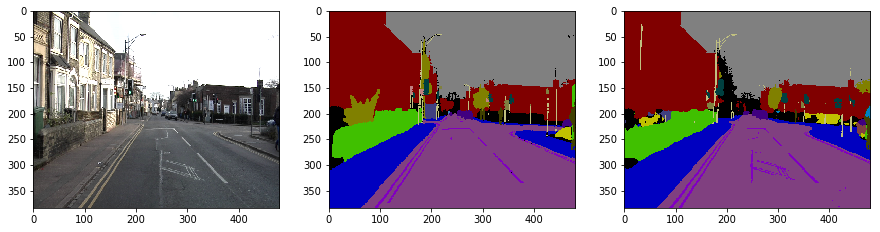

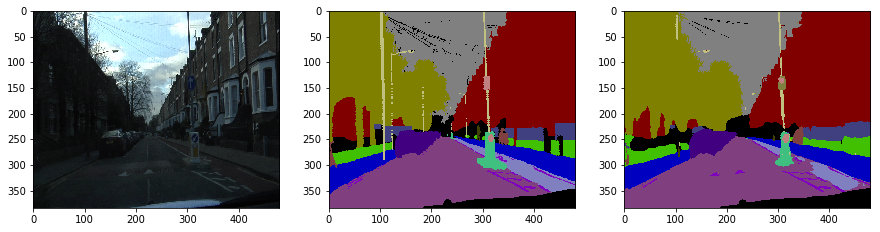

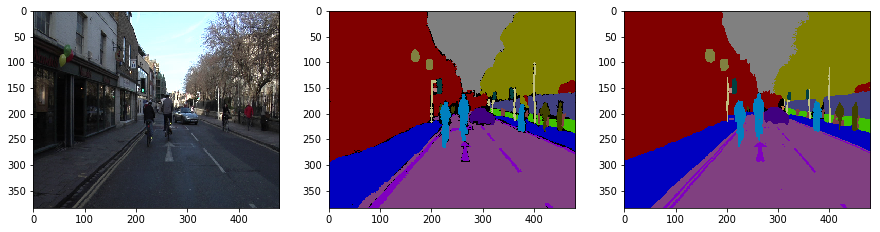

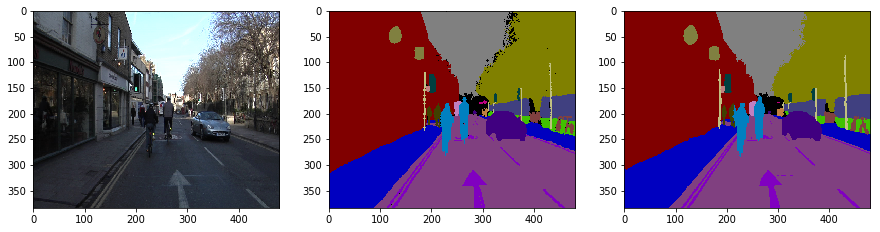

In [10]:
print('Original image / true labels / predicted labels')
for i in range(len(predicted_labels)):
    image = unnormalize_image(images[i])    
    y_true = labels[i].reshape((image.shape[0],image.shape[1]))
    y_true = color_label(y_true, label_colors)
    y_pred = predicted_labels[i].reshape((image.shape[0],image.shape[1]))
    y_pred = color_label(y_pred, label_colors)
    show_image_row([image, y_true, y_pred])
    plt.show()        